In [2]:
import os
import json

from PIL import Image
import redbrick

# see https://docs.redbrickai.com/python-sdk/sdk-overview#running-inside-of-a-jupyter-notebook
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.dpi"] = 200

## Export Masks from RedBrick AI

Export masks using the SDK. This will download your masks to a local directory, please see https://docs.redbrickai.com/python-sdk/export-1#png-masks for a description of formats. 

<b>Skip this step if</b> you want to use the masks/images provided with this example

In [ ]:
# Standard SDK setup, export masks. 
api_key = "TODO"
org_id = "TODO"
project_id = "TODO"
url = "TOOD"

project = redbrick.get_project(api_key, url, org_id, project_id)
project.export.redbrick_png(True)

## Interact with downloaded masks

Mask Shape =  (375, 500, 4)


Text(0.5, 1.0, 'RGB mask')

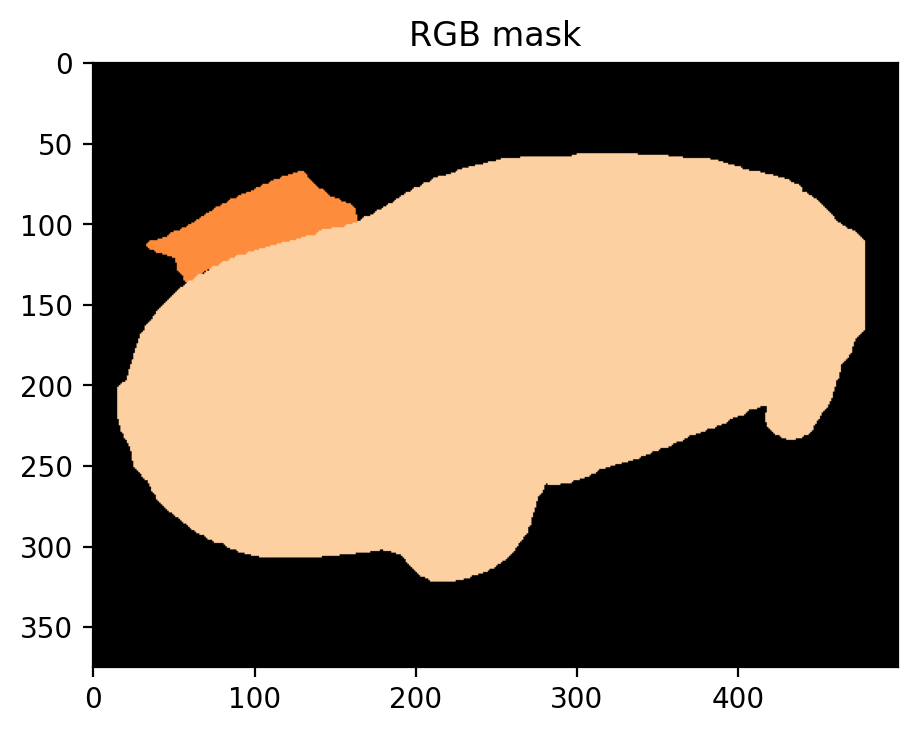

In [4]:
# Read in the mask as a 3 channel RGB image, with pixel values as np.uint8
mask_dir = "masks" # TODO: replace if you exported your own data above
masks = os.listdir(mask_dir)

# visulize a single mask
mask_instance = np.array(Image.open(os.path.join(mask_dir, masks[0])))

print("Mask Shape = ", mask_instance.shape)
plt.imshow(mask_instance)
plt.title("RGB mask")

Conver the RGB masks exported by RedBrick AI into single channel masks, where the pixel values are your class id's. 

Mask shape =  (375, 500)


Text(0.5, 1.0, 'Single channel mask')

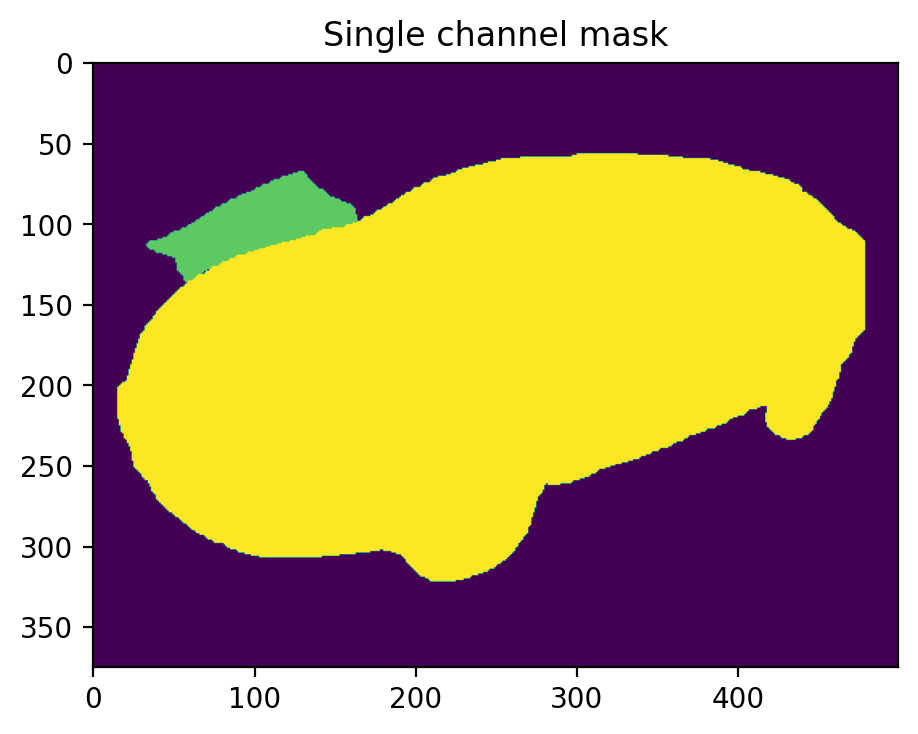

In [5]:
# Create a class_id object, category -> class id
class_id_map = {}
with open(os.path.join(mask_dir, "class_map.json"), "r") as file: 
    class_map = json.load(file)

id = 1
for category in class_map:
    class_id_map[category] = id
    id += 1

# Replace RGB, with the class_id
mask_instance_single_channel = np.zeros((mask_instance.shape[0], mask_instance.shape[1]))
for category in class_map: 
    color = class_map[category]
    index_match = np.where(
        mask_instance[:, :, 0] == color[0],
        mask_instance[:, :, 1] == color[1],
        mask_instance[:, :, 2] == color[2]
    )
    mask_instance_single_channel[index_match] = class_id_map[category]

print("Mask shape = ", mask_instance_single_channel.shape)
plt.imshow(mask_instance_single_channel)
plt.title("Single channel mask")

## Upload masks to a new RedBrick AI Project

In [7]:
api_key = "3tLQalOuq8sRcZIL5lhfVXBc6d1KPe3OhkGUDVJDuAE"
org_id = "3d0caac7-b1e9-483f-8676-c0aca73af232"
url = "https://api.redbrickai.com"
redbrick_organization = redbrick.get_org(api_key, url, org_id)

redbrick_project = redbrick_organization.create_project(
    name="Segmentation project", 
    label_type=redbrick.LabelType.IMAGE_SEGMENTATION, 
    taxonomy_name="DEFAULT::Berkeley Deep Drive (BDD)", 
    reviews=1
)

In [ ]:
import redbrick
with open("masks/datapoint_map.json", "r") as file: 
    # maps from mask name, to image name
    datapoint_map = json.load(file)

for mask in datapoint_map: 
    mask_array = np.array(Image.open(os.path.join(mask_dir, mask)))[:, :, 0:3]
    assert mask_array.dtype == np.uint8

    redbrick_project.upload.create_datapoint_from_masks(
        storage_id=redbrick.StorageMethod.REDBRICK,
        mask=mask_array,
        class_map=class_map, 
        image_path=datapoint_map[mask]
    )